Title: How to Handle Unbalanced Classes
Date: 2019-04-15 23:40
Category: Preprocessing
Tags: imblearn
Slug: unbalancedclasses

In machine learning, working with unbalanced classes can be challenging. Unbalanced classes occurs when there's an unequal representation of classes, where the minority class is often of higher interest to us. This is prominent in areas where data collection of the minority classes is difficult due to time and cost constraints. For example, if you consider classification problems such as non-fraud vs fraud and no-cancer vs cancer, fraudulent transactions and cancer patients are more rare than normal transactions and healthy patients. Other examples include oil spill detection, network intrusion detection, other rare diseases, etc.

## Challenges
Machine learning algorithms are built to minimize errors. For unbalanced datasets, since instances of the majority class is outnumbering the minority classes, the classifiers will more likely classify new data to the majority class. 

For example, if you had a dataset with 90% no-cancer (healthy) and 10% cancer, the classifier will be bias to classify a new person as having no-cancer (healthy) as it would be 90% accurate. This leads to `False Negatives`, which in the case of cancer, could be seen as more costly than having `False Positives`! A patient is told they don't have cancer, when they actually do... do you see the problem here?

## So, what can we do?
Here are some techniques you can consider when dealing with unbalanced classes. We will further elaborate and explore the imbalanced-learn API.

1. **Weigh observations** - Some models allow for hyperparameter tweaking of `class_weight` (i.e. Logistic Regression, Random Forests, SVMs)
2. Change the algorithm - For example, decision trees perform well on unbalanced classes
3. Purposely optimize between **evaluation metrics** - Consider optimizing for specific metrics other than accuracy, such as `precision` and `recall` ([img url](https://en.wikipedia.org/wiki/Precision_and_recall#/media/File:Precisionrecall.svg))
4. **Re-sampling** with imbalanced-learn

<img src="images/precisionrecall.svg" alt="precisionrecall" width="350">

## Re-sample with imbalanced-learn
`imbalanced-learn` is a python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance. It includes strategies for undersampling, oversampling, and a combination of both. 

Here we will:

- Generate our own imbalance datasets
- Use Altair to visual how different imlearn oversampling and hybrid strategies impact our classification predictions (y_pred), and
- Consider how it impacts `accuracy`, `precision` and `recall` scores

We will be making predictions using a Logistic Regression model throughout as an example.

In [1]:
# Import librairies
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

In [2]:
# Generate an imbalanced dataset
X, y = make_classification(n_samples = 1_000, n_features = 2, n_informative = 2,
    n_redundant = 0, n_repeated = 0, n_classes = 3,
    n_clusters_per_class = 1,
    weights = [0.01, 0.04, 0.95],
    class_sep = 0.8, random_state = 42)

In [3]:
# Method to generate scatter plot, color labeling the 3 classes
def alt_chart(X, y, title):
    df = pd.DataFrame({'x1': X[:,0],
                   'x2': X[:,1],
                   'y': y
                 })
    return alt.Chart(df).mark_circle().encode(
        x = 'x1',
        y = 'x2',
        color = alt.Color('y:N',
              scale = alt.Scale(domain = ['0', '1', '2'],
                          range = ['blue', 'orange', 'red'])),
    ).properties(
        title = title, 
        width = 250, 
        height = 150
    )

In [4]:
# Method to rebalance train data, model a logistic regression, and output charts for predictions on test data
# Inputs: X data, y data, rebalance algorithm (i.e. SMOTE()), rebalancing_title as a str (i.e. 'SMOTE')
def rebalance_train_test_logreg(X, y, rebalance_alg, rebalancing_title):

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # Rebalance train data
    rebalance = rebalance_alg
    X_reb, y_reb = rebalance.fit_sample(X_train, y_train)

    # Train a Logistic Regression model on resampled data
    logreg = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')
    logreg.fit(X_reb, y_reb)

    # Generate predictions
    y_pred = logreg.predict(X_test)
    
    # Generate charts
    left_top = alt_chart(X_train, y_train, 'y_train')
    right_top = alt_chart(X_reb, y_reb, 'y_train_resampled')
    top = left_top | right_top
    
    left_bottom = alt_chart(X_test, y_test, 'y_test')
    right_bottom = alt_chart(X_test, y_pred, f'y_pred ({rebalancing_title})')
    bottom = left_bottom | right_bottom
    
    # Print out metrics
    print(f' Accuracy Score: {accuracy_score(y_test, y_pred)}')
    print(f' Precision Score: {precision_score(y_test, y_pred, average = None)}')
    print(f' Recall Score: {recall_score(y_test, y_pred, average = None)}')
    
    return top & bottom

Before we dive into resampling our data, let's see how a logistic regression model would do with our original dataset.
## Original (unbalanced) Dataset

 Accuracy Score: 0.965
 Precision Score: [0.         0.85714286 0.96891192]
 Recall Score: [0.         0.66666667 0.99468085]


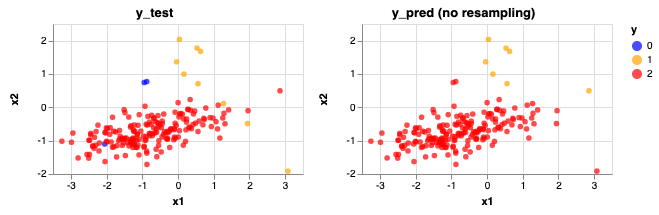

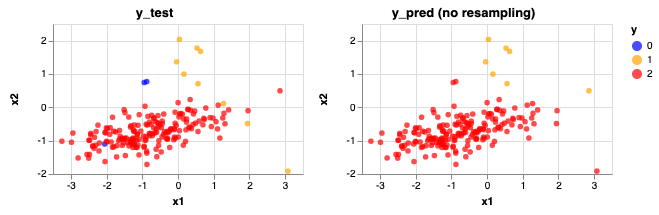

In [5]:
import warnings
warnings.filterwarnings('ignore')

# predictions without resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
logreg = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
left = alt_chart(X_test, y_test, 'y_test')
right = alt_chart(X_test, y_pred, f'y_pred (no resampling)')

print(f' Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f' Precision Score: {precision_score(y_test, y_pred, average = None)}')
print(f' Recall Score: {recall_score(y_test, y_pred, average = None)}')
    
left | right

As you can see this is problematic when making predictions on the test data. Even though the accuracy score is high, our model can not identify Class 0 at all (no blue dot present) and some of the Class 1 data are being predicted as Class 2. 

## Over-sampling Methods
For more information on how samples are generated using these different methods, you can refer to [imblearn's documentation](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#mathematical-formulation). 

### 1. SMOTE 
SMOTE stands for *Synthetic Minority Over-sampling Technique*. It generates new synthetic minority samples between existing minority samples by interpolation (focused on connecting inliers and outliers). The algorithm adds random points between existing minority samples and its n-nearest neighbors (default = 5, a hyperparameter that can be tweaked) for each of the samples in the class ([img url]( https://www.researchgate.net/publication/287601878/figure/fig1/AS:316826589384744@1452548753581/The-schematic-of-NRSBoundary-SMOTE-algorithm.png)).

<img src="images/SMOTE.png" alt="SMOTE" width="400">

 Accuracy Score: 0.785
 Precision Score: [0.06896552 0.34782609 0.99324324]
 Recall Score: [0.66666667 0.88888889 0.78191489]


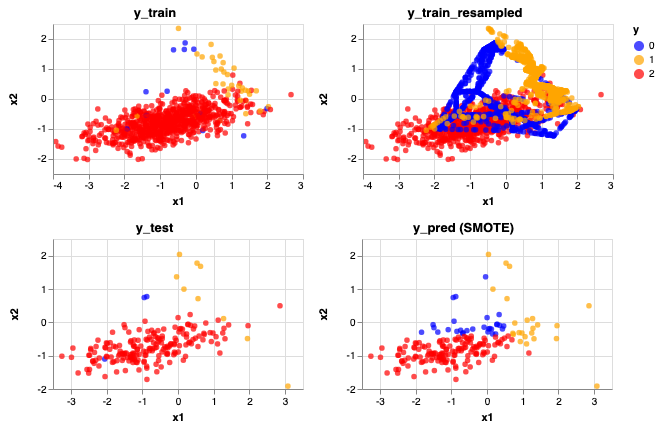

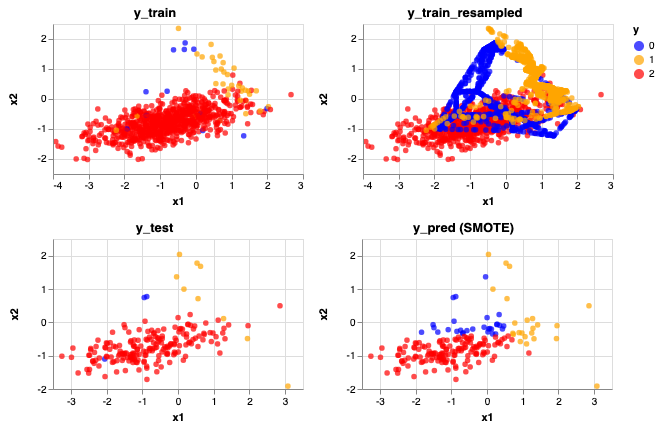

In [6]:
rebalance_train_test_logreg(X, y, SMOTE(), 'SMOTE')

Compared to the unbalanced classes, here we can identify some of the blue (Class 0) dots. That's why the recall score for that Class increased from 0 to 0.67. However, you can see that with this method, it also over identifies the blue (Class 0) and yellow (Class 1) dots. This can also be shown by lower precision scores for these two classes. 

### 2. ADASYN
ADASYN stands for *Adaptive Synthetic*, a slightly improved method from SMOTE. ADASYN works in a similiar way by interpolation, but focuses on generating synthetic samples next to original samples that are harder to learn than those that are easier to learn (focusing on outliers). Hence, this helps to shift the classification decision boundary towards the difficult samples.

 Accuracy Score: 0.725
 Precision Score: [0.05882353 0.29032258 0.99259259]
 Recall Score: [0.66666667 1.         0.71276596]


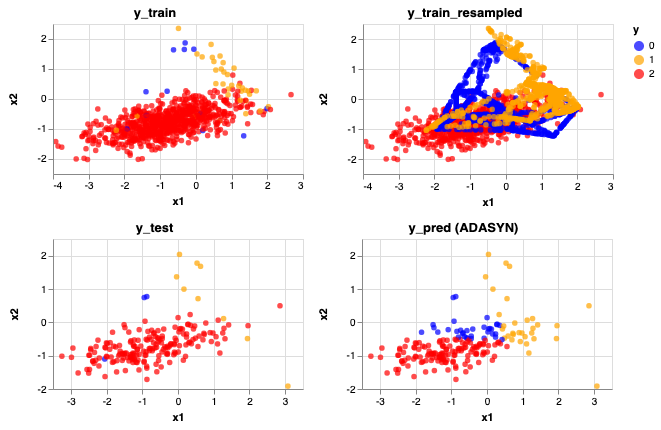

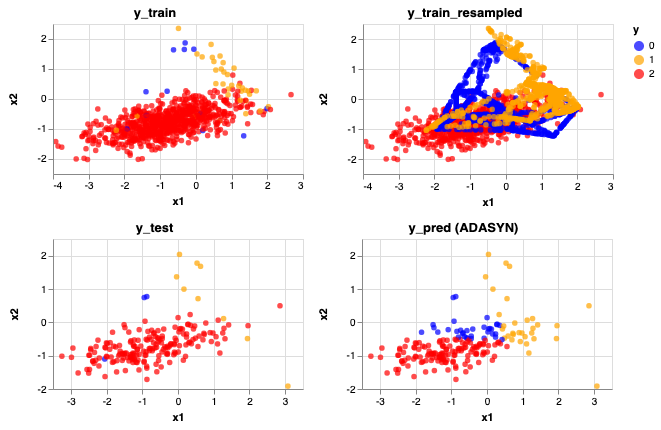

In [7]:
rebalance_train_test_logreg(X, y, ADASYN(), 'ADASYN')

The predictions looks very similar after resampling with ADASYN looks very similar to SMOTE, maybe a few more yellow (Class 1) data are now being predicted correctly. 

### 3. BorderlineSMOTE
BorderlineSMOTE is a variant of SMOTE, a method focused on samples near of the border of the optimal decision function and will generate samples in the opposite direction of the nearest neighbors class.

 Accuracy Score: 0.955
 Precision Score: [0.5        0.58333333 0.98913043]
 Recall Score: [0.66666667 0.77777778 0.96808511]


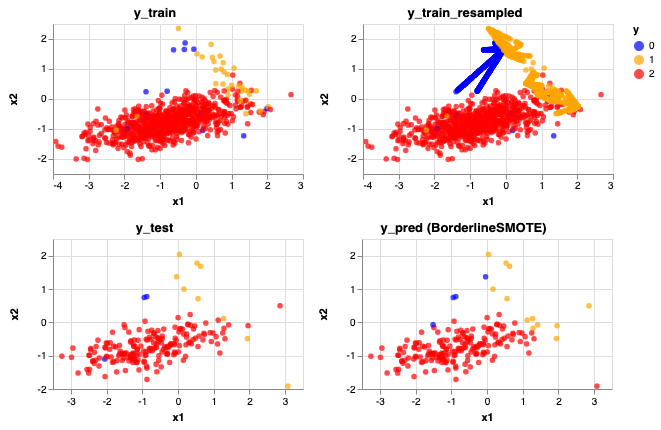

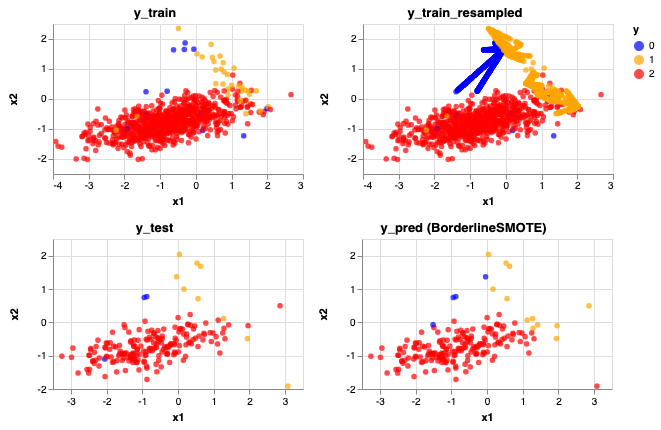

In [8]:
rebalance_train_test_logreg(X, y, BorderlineSMOTE(), 'BorderlineSMOTE')

Predictions don't look too bad! An improvement from SMOTE and ADASYN. Accuracy score has increased to 0.955 but also the precision and recall scores for the minority classes also increased on average.  

## Hybrid Approach (Combination of Over-sampling Under-sampling)
With SMOTE above, you can see that the data got a lot noisier. If you choose to do so, under-sampling (after over-sampling) can help to clean this up in hopes to better our predictions. More information can be found in [imlearn's documentation](https://imbalanced-learn.readthedocs.io/en/stable/combine.html).
### 1. SMOTETomek
This method applies the SMOTE method described above then undersamples based on `Tomek's link`. A Tomek’s link exist if the two samples (from different classes) are the nearest neighbors of each other. Based on selection for the hyperparameter `sampling_strategy`, this removes one to all of the samples in the link (default: 'auto', which removes samples from the majority class).

Alternatively, you can choose to resample the data by only undersampling using `imblearn.under_sampling.TomekLinks` (without oversampling with SMOTE first) ([img url](https://imbalanced-learn.readthedocs.io/en/stable/_images/sphx_glr_plot_illustration_tomek_links_001.png)).

<img src="images/Tomek.png" alt="Tomek" width="400">

 Accuracy Score: 0.765
 Precision Score: [0.06060606 0.34782609 0.99305556]
 Recall Score: [0.66666667 0.88888889 0.7606383 ]


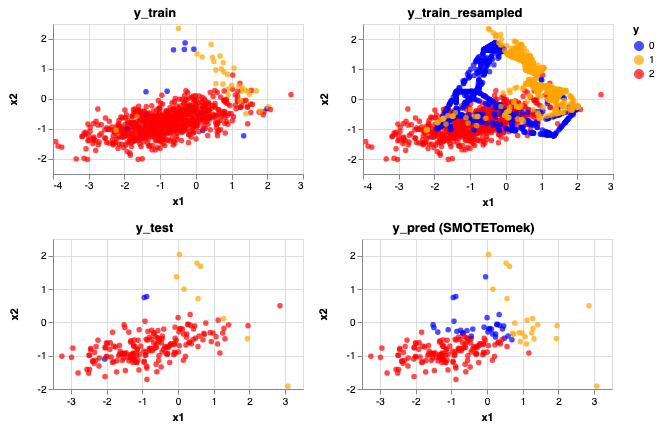

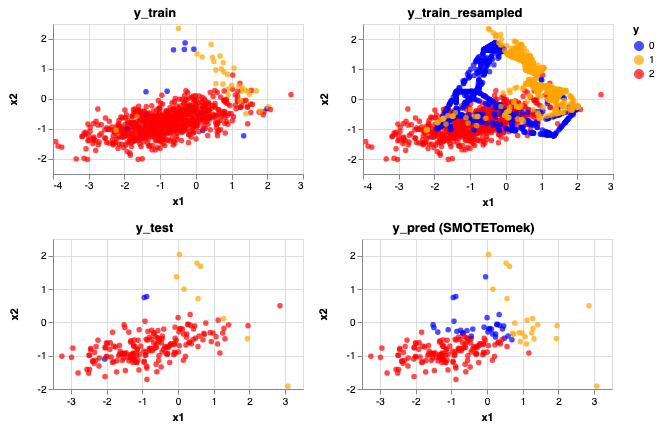

In [9]:
rebalance_train_test_logreg(X, y, SMOTETomek(), 'SMOTETomek')

### 2. SMOTEENN
This method applies the SMOTE method described above then undersamples based on `EditedNearestNeighbours`, which applies a nearest-neighbors algorithm and removes samples if they do not agree “enough” with their neighboorhood.

Two selection criteria are currently available:

1. `kind_sel` = 'mode', the majority vote of the neighbours will be used in order to exclude a sample
2. `kind_sel` = 'all', all neighbours will have to agree with the samples of interest to not be excluded

Alternatively, you can choose to resample the data by only undersampled using `imblearn.under_sampling.EditedNearestNeighbours` (without oversampling with SMOTE first). 

 Accuracy Score: 0.69
 Precision Score: [0.03921569 0.36842105 0.99230769]
 Recall Score: [0.66666667 0.77777778 0.68617021]


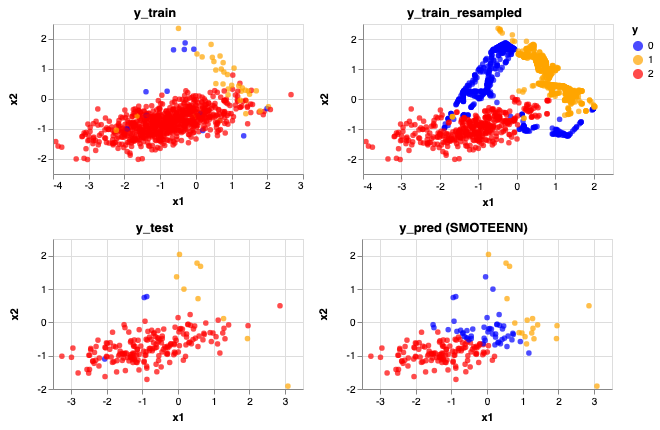

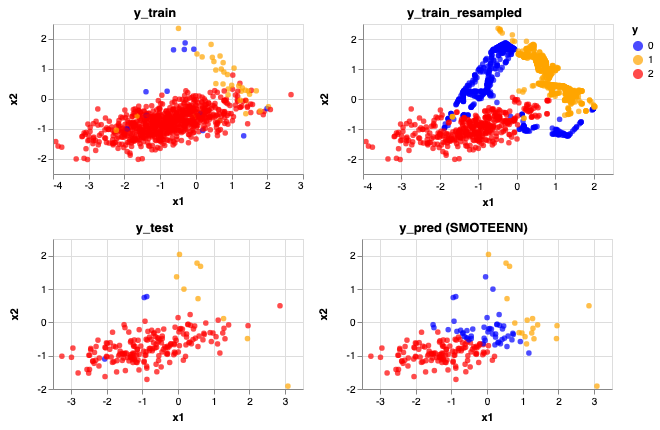

In [10]:
rebalance_train_test_logreg(X, y, SMOTEENN(), 'SMOTEENN')

## Advantages and Limitations of SMOTE
SMOTE is a powerful over-sampling algorithm, which I prefer over the `imblearn.over_sampling.RandomOverSampler()` and `imblearn.under_sampling.RandomUnderSampler()` algorithms. Instead of randomly choosing samples from the minority class to duplicate or to remove, it goes beyond the naive way of creating or removing samples. This prevents overfitting (with created duplicated samples) and prevents the risk of randomly removing important samples. 

However, one limitation of SMOTE is that it blindly re-samples the minority class without considering how sparse and separated the minority classes are compared to the majority class. In our example, you can see that the blue and yellow dots are somewhat spread into and within the red dots. With SMOTE, it blindly overpopulated these classes with it's algorithm, which increased class mixture. As a result, it predicted more blue and yellow dots than desired.

In this specific example, I actually really like the alternate `BorderLineSMOTE` algorithm!

## Conclusion
We've only covered a handful of resampling methods offered from `imblearn` ([the full list](https://imbalanced-learn.readthedocs.io/en/stable/api.html#)). For tackling unbalanced classes, resampling is also only one possible solution amongst other mentioned earlier:

1. Weigh observations
2. Consider other metrics (i.e. precision, recall, ROC AUC)
3. Change the algorithm
4. Re-sampling (undersampling, oversampling, under and oversampling)

You should always consider separation and sparsity of your classes, try different approaches, and see which one works best for different problems!